<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/KOI_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KOI Regression

One of the objectives of the project is to link properties of a confirmed exoplanet and its host star to the radius of the exoplanet.

To this end, we will take advantage of the **Kepler Object of Interest Table (KOI)**, which provides the most accurate dispositions (false positive, confirmed, candidate) and stellar and planetary information for all KOIs in one place. We will load it, filter the table to only consider confirmed KOIs, retrieve the desired parameters, use a Multi-layer Perceptron (MLP) regressor to predict radii, and plot the results.

 We will only be looking at several parameters, but the table is rich and can be explored in many more ways.

## Acquiring and splitting the data

Notes:

*   **X**: The input data
  *   `koi_period` = orbital period (days)
  *   `koi_time0bk` = transit epoch, or the time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days
  *   `koi_impact` = impact parameter
  *   `koi_duration` = duration (hours)
  *   `koi_depth` = depth (parts per million)
  *   planet mass
*   **Y**: The target values (radii)

[link to KOI data columns dictionary](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import neural_network
from sklearn.model_selection import train_test_split

From the KOI table, we filter out all non-`CONFIRMED` rows to extract input parameters and known exoplanet radii.
<br/>


The stellar mass is calculated by,
<br/>
$M_{*}$ $=$ $\frac{g_{*}R_{*}^2}{G}$
<br/>
where $g_{*}$ is the stellar surface gravity, $R_{*}$ is the stellar radius, and $G$ is the gravitational constant.
<br/>


We split the data 50% **training**, 25% **testing**, and 25% **validation**.

[link to sklearn regression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)


In [2]:
# KOI filtering 
url = "https://raw.githubusercontent.com/nicholasproietti/LGM/main/data/KOI.csv"

KOI = pd.read_csv(url)
KOI_confirmed = KOI.drop(KOI[KOI['koi_disposition']!='CONFIRMED'].index)

# planet mass calculation
G = 6.673*pow(10, -8) # gravitational constant in base cgs units
mass = ((10**KOI_confirmed['koi_slogg'])*pow(KOI_confirmed['koi_srad'], 2))/G # stellar mass

# extract input parameters and known radii 
x = KOI_confirmed[['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth']]
x.loc[:,'mass'] = pd.Series(np.random.randn(len(x)), index=x.index)
x.loc[:, 'mass'] = mass
y = KOI_confirmed[['koi_prad']]
x = x.fillna(0)
y = y.fillna(0)

# split the data
from sklearn import preprocessing
x_scaled = preprocessing.scale(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled[1:6000], y[1:6000], train_size=0.5, test_size=0.5)

# validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2
     



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. Yo

## Viewing the inputs and outputs for the MLP regressor

View the inputs

In [3]:
x

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,mass
0,9.488036,170.53875,0.146,2.9575,615.8,3.774317e+11
1,54.418383,162.51384,0.586,4.5070,874.8,3.774317e+11
4,2.525592,171.59555,0.701,1.6545,603.3,4.495130e+11
5,11.094321,171.20116,0.538,4.5945,1517.5,4.335223e+11
6,4.134435,172.97937,0.762,3.1402,686.0,4.335223e+11
...,...,...,...,...,...,...
8057,10.692115,141.11600,0.734,4.6570,408.4,4.730664e+11
8817,4.485592,135.43172,0.442,0.8161,2265.0,6.979005e+10
8956,8.152759,134.19046,0.461,1.7460,16536.0,6.943884e+10
9014,384.847556,314.97000,0.059,9.9690,189.9,3.628145e+11


View the outputs

In [4]:
y


,koi_prad
0,2.26
1,2.83
4,2.75
5,3.90
6,2.77
...,...
8057,2.71
8817,0.95
8956,2.44
9014,1.09


## Using the MLP regressor

Let's define two functions:

`test_validate1()` will plot the percent error between the predicted exoplanet radius from the MLP regressor and the known radius from the KOI table for every exoplanet in the validation set.

`test_validate2()` will plot the same set as `test_validate1()` with a different representation. The predicted **and** known exoplanet radius values will be plotted.

In [5]:
def test_validate1(x_test, y_test, y_predict, classifier, set_name):
    x = range(len(y_test))
    y_test = y_test.to_numpy()
    per_error = [abs(i-j)/i*100 if i != 0 else None for i,j in zip(y_test,y_predict)]
    #plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, per_error, "bo", markersize=6, zorder=2, label=u"$R$=%.3f" % classifier.score(x_test, y_test))
    plt.axhline(y=0, color='red', linestyle='--', linewidth=3, label="0% error")
    plt.legend(loc="upper left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius Percent Error (%)", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(per_error), -10, 100])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions " + '(' + set_name + ')', fontsize = 14)
    print("Mean percent error: " + str(round(np.mean(per_error), 3)))
    plt.show()

def test_validate2(x_test, y_test, y_predict, classifier, set_name):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"predicted, $R$=%.3f" % classifier.score(x_test, y_test))
    plt.legend(loc="lower left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius " + r"$(R_{earth})$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(y_test), -3,20])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions " + '(' + set_name + ')', fontsize = 14)
    plt.show()

plt.rcParams["figure.figsize"] = (10,7)

Now let's use the MLP regressor with default settings (`relu` activation function, `adam` solver, 2 hidden layers of 100 and 20 units respectively, etc.).

This model optimizes the squared error using LBFGS or stochastic gradient descent.

In [6]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 max_iter=2000,tol=1e-4)

mlp.fit(x_train, y_train)
r = mlp.score(x_train, y_train)
y_predict = mlp.predict(x_test)  

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Visualize the final results  of the KOI regression

For the testing and validation results, let's view how the predicted radii compare to the known radii.


### Testing Set

#### Accuracy of MLPRegressor Exoplanet Radii Predictions

Mean percent error: 23.088


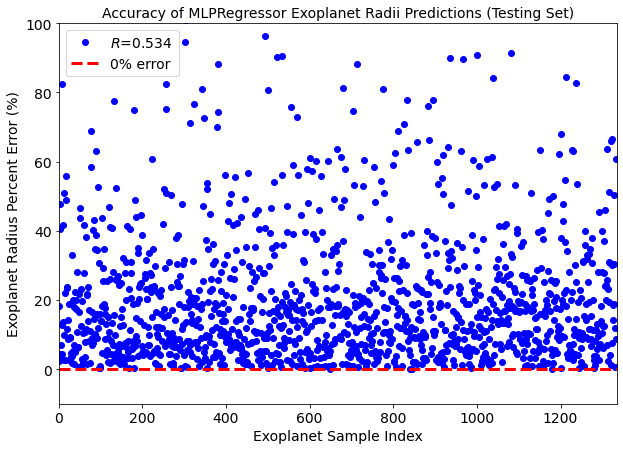

In [7]:
test_validate1(x_test=x_test, y_test=y_test, y_predict=y_predict, classifier=mlp, set_name='Testing Set')
     

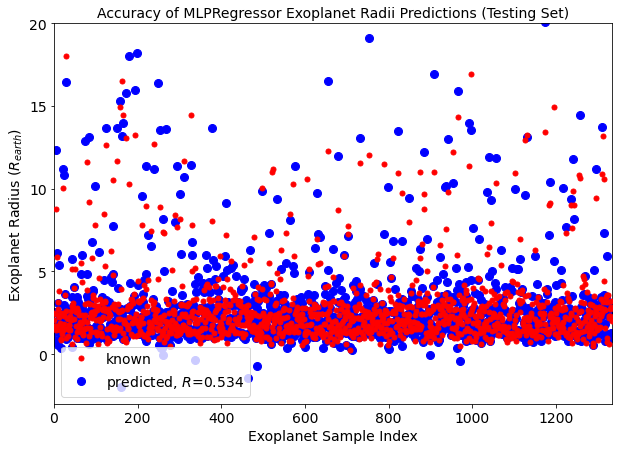

In [8]:
test_validate2(x_test=x_test, y_test=y_test, y_predict=y_predict, classifier=mlp, set_name='Testing Set')

#### Loss Curve

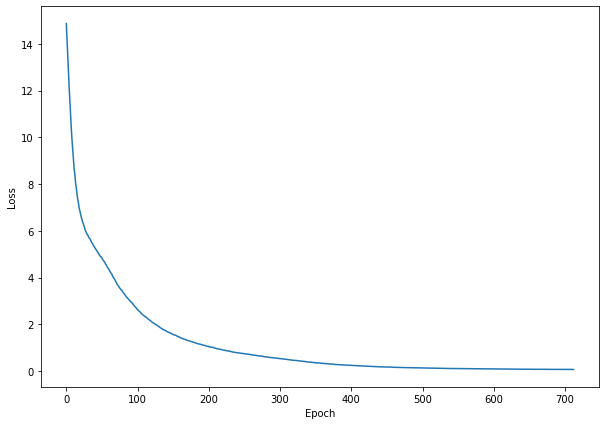

In [9]:
pd.DataFrame(mlp.loss_curve_).plot(xlabel="Epoch", ylabel="Loss", legend=False)


### Validation Set

In [14]:
y_val_pred = mlp.predict(x_val)

#### Accuracy of MLPRegressor Exoplanet Radii Predictions

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


TypeError: ignored

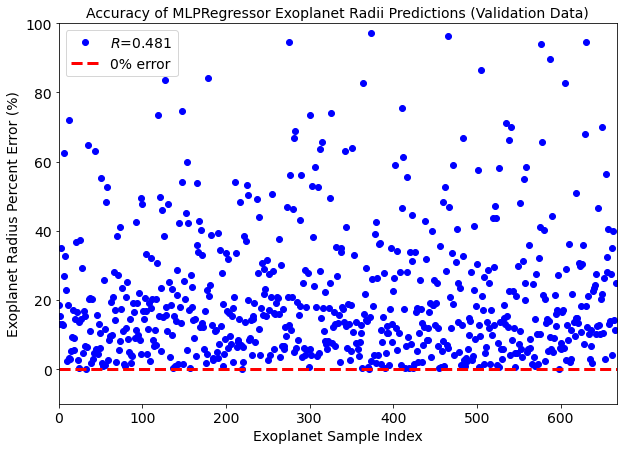

In [16]:
test_validate1(x_val, y_val, y_val_pred, mlp, 'Validation Data')    

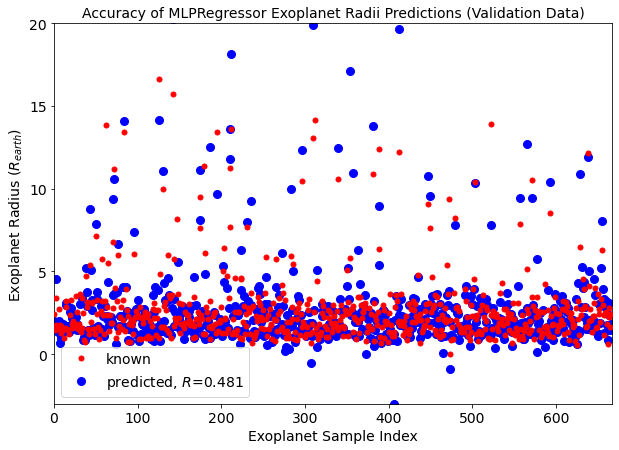

In [17]:
test_validate2(x_val, y_val, y_val_pred, mlp, 'Validation Data')